# Test Detic

## Aim
- Is it accurate?
- Is it trainable with children's drawing?

## Test
- tested using https://colab.research.google.com/drive/1JpZlFZxraIU1629TAQcVqEHYqUg7pBKl#scrollTo=CDeCPfiomTGG

---
- 2022-05-28 jkang first tested

In [1]:
from PIL import Image

import os
import sys
import numpy as np
import os, json, cv2, random

import torch

# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# Import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

# Detic libraries
sys.path.insert(0, 'third_party/CenterNet2/')
from centernet.config import add_centernet_config
from detic.config import add_detic_config
from detic.modeling.utils import reset_cls_test

In [2]:
# Build the detector and download our pretrained weights
cfg = get_cfg()
add_centernet_config(cfg)
add_detic_config(cfg)
cfg.merge_from_file("configs/Detic_LCOCOI21k_CLIP_SwinB_896b32_4x_ft4x_max-size.yaml")
cfg.MODEL.WEIGHTS = 'https://dl.fbaipublicfiles.com/detic/Detic_LCOCOI21k_CLIP_SwinB_896b32_4x_ft4x_max-size.pth'
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # set threshold for this model
cfg.MODEL.ROI_BOX_HEAD.ZEROSHOT_WEIGHT_PATH = 'rand'
cfg.MODEL.ROI_HEADS.ONE_CLASS_PER_PROPOSAL = True # For better visualization purpose. Set to False for all classes.
# cfg.MODEL.DEVICE='cpu' # uncomment this to use cpu-only mode.
predictor = DefaultPredictor(cfg)

/home/jkang/anaconda3/envs/detic/lib/python3.9/site-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /opt/conda/conda-bld/pytorch_1639180487213/work/aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[05/28 21:15:22 d2.checkpoint.c2_model_loading]: Following weights matched with model:
| Names in Model                                          | Names in Checkpoint                                                                                                                         | Shapes                                                   |
|:--------------------------------------------------------|:--------------------------------------------------------------------------------------------------------------------------------------------|:---------------------------------------------------------|
| backbone.bottom_up.layers.0.blocks.0.attn.*             | backbone.bottom_up.layers.0.blocks.0.attn.{proj.bias,proj.weight,qkv.bias,qkv.weight,relative_position_bias_table,relative_position_index}  | (128,) (128,128) (384,) (384,128) (169,4) (49,49)        |
| backbone.bottom_up.layers.0.blocks.0.mlp.fc1.*          | backbone.bottom_up.layers.0.blocks.0.mlp.fc1.{bias,weight}            

In [3]:
# Setup the model's vocabulary using build-in datasets

BUILDIN_CLASSIFIER = {
    'lvis': 'datasets/metadata/lvis_v1_clip_a+cname.npy',
    'objects365': 'datasets/metadata/o365_clip_a+cnamefix.npy',
    'openimages': 'datasets/metadata/oid_clip_a+cname.npy',
    'coco': 'datasets/metadata/coco_clip_a+cname.npy',
}

BUILDIN_METADATA_PATH = {
    'lvis': 'lvis_v1_val',
    'objects365': 'objects365_v2_val',
    'openimages': 'oid_val_expanded',
    'coco': 'coco_2017_val',
}

vocabulary = 'lvis' # change to 'lvis', 'objects365', 'openimages', or 'coco'
metadata = MetadataCatalog.get(BUILDIN_METADATA_PATH[vocabulary])
classifier = BUILDIN_CLASSIFIER[vocabulary]
num_classes = len(metadata.thing_classes)
reset_cls_test(predictor.model, classifier, num_classes)

Resetting zs_weight datasets/metadata/lvis_v1_clip_a+cname.npy


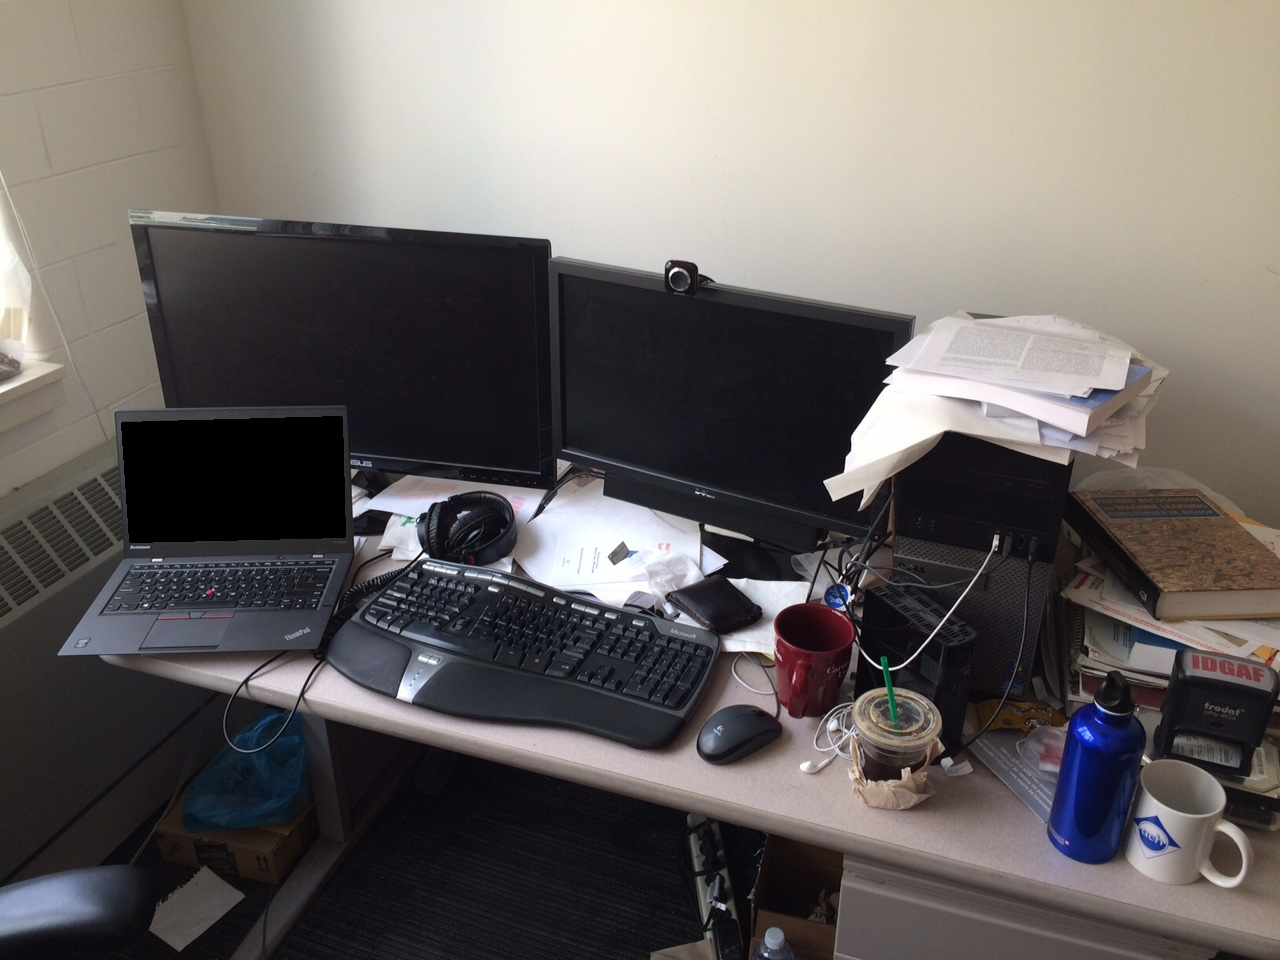

In [4]:
# Download a sample image and display. Replace path here to try your own images!
# !wget https://web.eecs.umich.edu/~fouhey/fun/desk/desk.jpg
# im = cv2.imread("./desk.jpg")
# cv2.imshow('tet', im)
im = Image.open('desk.jpg')
im

In [7]:
# Run model and show results
img_array = np.asarray(im)
outputs = predictor(img_array)
v = Visualizer(img_array[:, :, ::-1], metadata)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))

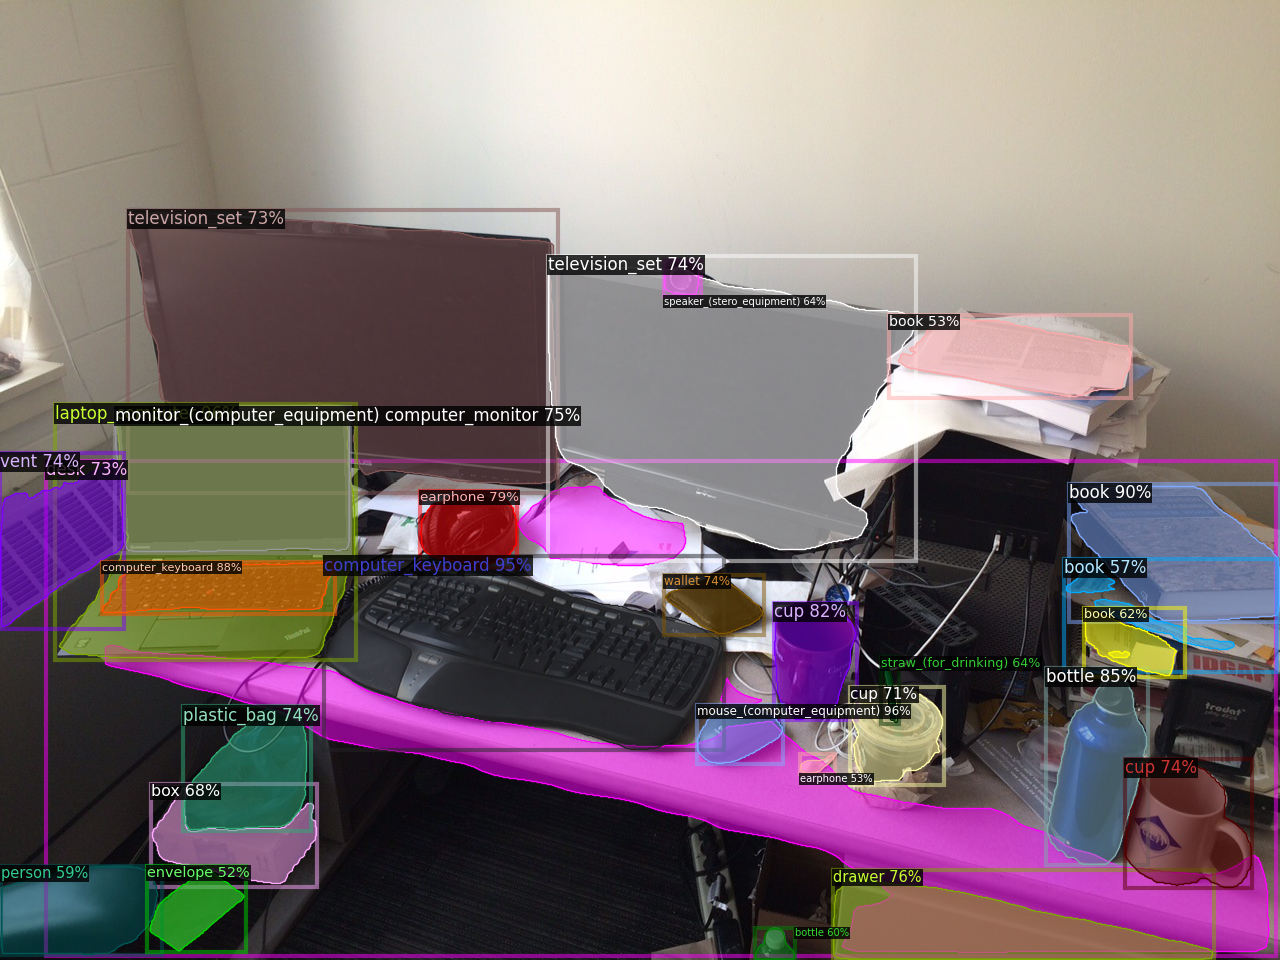

In [9]:
Image.fromarray(out.get_image()[:, :, ::-1])

In [10]:
# Change the model's vocabulary to a customized one and get their word-embedding 
#  using a pre-trained CLIP model.

from detic.modeling.text.text_encoder import build_text_encoder
def get_clip_embeddings(vocabulary, prompt='a '):
    text_encoder = build_text_encoder(pretrain=True)
    text_encoder.eval()
    texts = [prompt + x for x in vocabulary]
    emb = text_encoder(texts).detach().permute(1, 0).contiguous().cpu()
    return emb
  
vocabulary = 'custom'
metadata = MetadataCatalog.get("__unused")
metadata.thing_classes = ['headphone', 'webcam', 'paper', 'coffee'] # Change here to try your own vocabularies!
classifier = get_clip_embeddings(metadata.thing_classes)
num_classes = len(metadata.thing_classes)
reset_cls_test(predictor.model, classifier, num_classes)
# Reset visualization threshold
output_score_threshold = 0.3
for cascade_stages in range(len(predictor.model.roi_heads.box_predictor)):
    predictor.model.roi_heads.box_predictor[cascade_stages].test_score_thresh = output_score_threshold

100%|███████████████████████████████████████| 338M/338M [00:26<00:00, 13.4MiB/s]


Loading pretrained CLIP


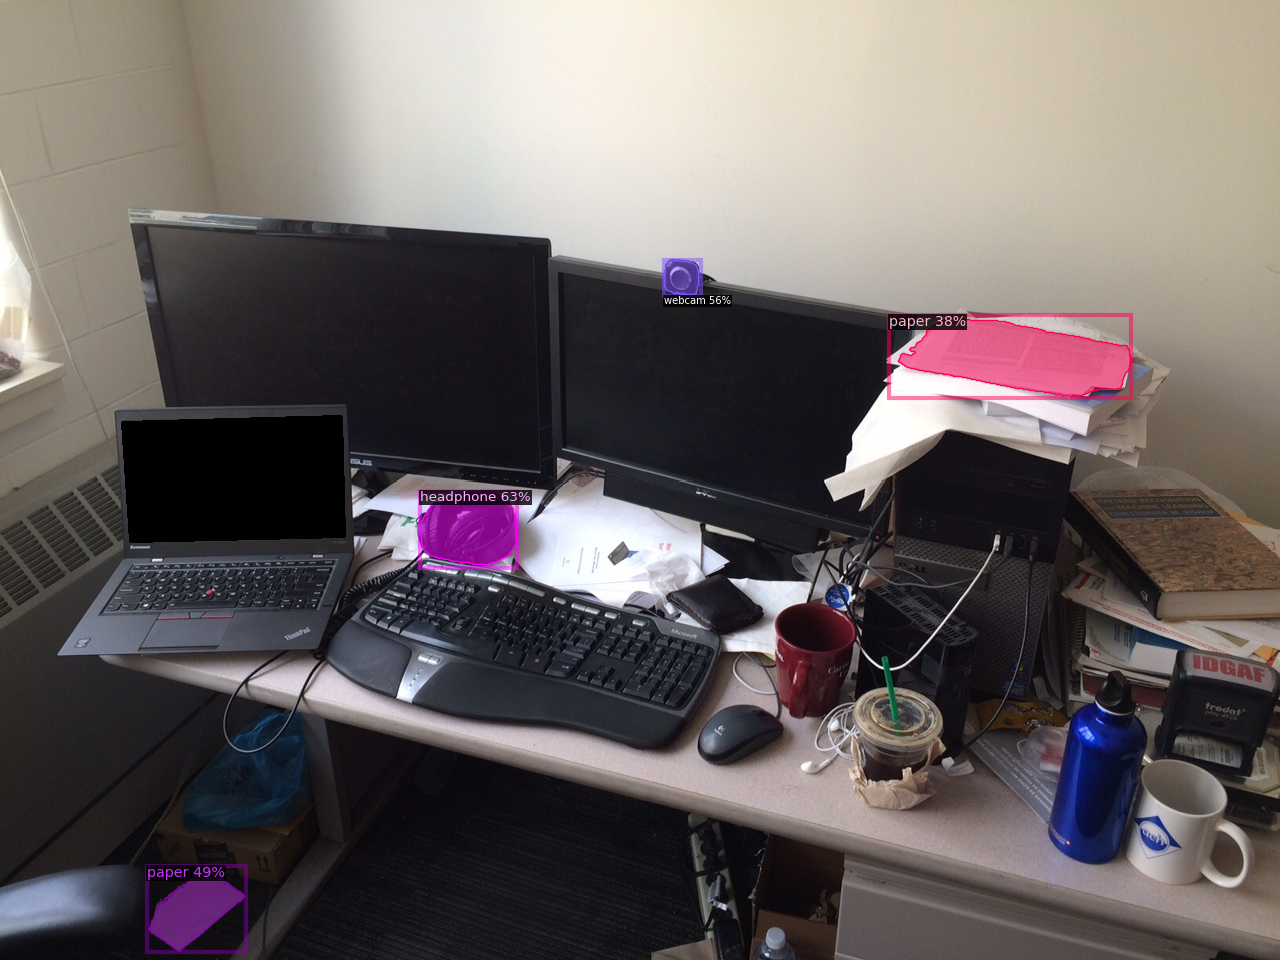

In [11]:
# Run model and show results
outputs = predictor(img_array)
v = Visualizer(img_array[:, :, ::-1], metadata)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
Image.fromarray(out.get_image()[:, :, ::-1])

In [12]:
# look at the outputs. 
# See https://detectron2.readthedocs.io/tutorials/models.html#model-output-format for specification
print(outputs["instances"].pred_classes) # class index
print([metadata.thing_classes[x] for x in outputs["instances"].pred_classes.cpu().tolist()]) # class names
print(outputs["instances"].scores)
print(outputs["instances"].pred_boxes)

tensor([0, 1, 2, 2], device='cuda:0')
['headphone', 'webcam', 'paper', 'paper']
tensor([0.6329, 0.5598, 0.4936, 0.3775], device='cuda:0')
Boxes(tensor([[ 419.9630,  491.1545,  517.3748,  568.2632],
        [ 663.7294,  259.8568,  701.0115,  295.7442],
        [ 147.4438,  865.8932,  246.0177,  952.0464],
        [ 888.9614,  315.2662, 1131.4152,  398.4488]], device='cuda:0'))


# Next step: 220528 새로 노트북 하나 만들어서 아이들 그림 넣고 테스트해보기